A notebook for trying and working on the libraries to be used

Using Jaxns jones example to test out stuff

In [35]:
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import numpy as jnp
from jax import random

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
from jaxns import analytic_log_evidence

tfpd = tfp.distributions

In [2]:
TEC_CONV = -8.4479745  #rad*MHz/mTECU
CLOCK_CONV = (2e-3 * jnp.pi)  #rad/MHz/ns


def wrap(phi):
    return (phi + jnp.pi) % (2 * jnp.pi) - jnp.pi


def generate_data(key, uncert):
    """
    Generate gain data where the phase have a clock const and tec component. This is a model of the impact of the ionosphere on the propagation of radio waves, part of radio interferometry:

    phase[:] = tec * (tec_conv / freqs[:]) + clock * (clock_conv * freqs[:]) + const

    then the gains are:

        gains[:] ~ Normal[{cos(phase[:]), sin(phase[:])}, uncert^2 * I]

    phase_obs[:] = ArcTan[gains.imag, gains.real]

    Args:
        key:
        uncert: uncertainty of the gains

    Returns:
        phase_obs, freqs
    """
    freqs = jnp.linspace(121, 166, 24)  #MHz
    tec = 90.  #mTECU
    const = 2.  #rad
    clock = 0.5  #ns
    phase = wrap(tec * (TEC_CONV / freqs) + clock * (CLOCK_CONV * freqs) + const)
    Y = jnp.concatenate([jnp.cos(phase), jnp.sin(phase)], axis=-1)
    Y_obs = Y + uncert * random.normal(key, shape=Y.shape)
    phase_obs = jnp.arctan2(Y_obs[..., freqs.size:], Y_obs[..., :freqs.size])
    return phase, phase_obs, freqs

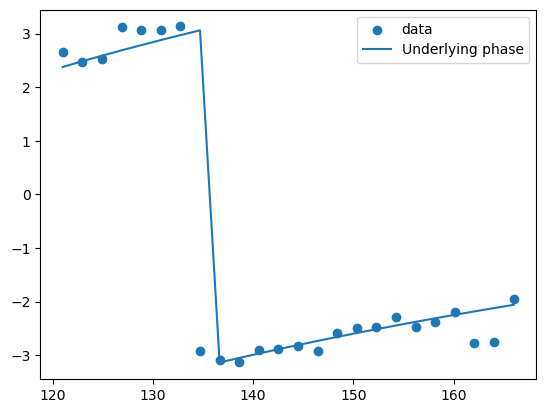

In [3]:
# Generate data
key = random.PRNGKey(43)
key, data_key = random.split(key)
phase_underlying, phase_obs, freqs = generate_data(data_key, 0.25)
plt.scatter(freqs, phase_obs, label='data')
plt.plot(freqs, phase_underlying, label='Underlying phase')
plt.legend()
plt.show()
# Note: the phase wrapping makes this a difficult problem to solve. As we'll see, the posterior is rather complicated.

In [15]:
from jaxns import Prior, Model


def log_normal(x, mean, scale):
    dx = (x - mean) / scale
    return -0.5 * jnp.log(2. * jnp.pi) - jnp.log(scale) - 0.5 * dx * dx


def log_likelihood(tec, const, clock, uncert):
    phase = tec * (TEC_CONV / freqs) + const + clock * (CLOCK_CONV * freqs)
    logL = log_normal(wrap(wrap(phase) - wrap(phase_obs)), 0., uncert)
    return jnp.sum(logL)

# We cannot use key word arguments in the log_likelihood function in jaxns
# We will have to give exact parameters to the function in any case

# def log_likelihood(**kwargs):
#     phase = kwargs["tec"] * (TEC_CONV / freqs) + kwargs["const"] + kwargs["clock"] * (CLOCK_CONV * freqs)
#     logL = log_normal(wrap(wrap(phase) - wrap(phase_obs)), 0., kwargs["uncert"])
#     return jnp.sum(logL)

def prior_model():
    tec = yield Prior(tfpd.Cauchy(0., 100.), name='tec')
    const = yield Prior(tfpd.Uniform(-jnp.pi, jnp.pi), name='const')
    clock = yield Prior(tfpd.Uniform(-2., 2.), name='clock')
    uncert = yield Prior(tfpd.HalfNormal(0.5), name='uncert')

    return tec, const, clock, uncert
    # return dict(tec=tec, const=const, clock=clock, uncert=uncert)


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

# log_Z_true = analytic_log_evidence(model=model, S=80)
# print(f"True log(Z)={log_Z_true}")

INFO[2023-05-31 22:08:48,684]: Sanity check...
INFO[2023-05-31 22:08:48,687]: Sanity check passed


In [5]:
# Create the nested sampler class. In this case without any tuning.
ns = exact_ns = ExactNestedSampler(model=model, num_live_points=500, max_samples=1e4, uncert_improvement_patience=2)

termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = exact_ns.to_results(state, termination_reason)

In [6]:
# We can use the summary utility to display results
exact_ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1106683
# samples: 7652
# slices: 174000.0
# slices / acceptance: 29.0
# likelihood evals / sample: 144.6
# likelihood evals / slice: 6.3
--------
logZ=-5.04 +- 0.12
H=45.0
ESS=1404
--------
clock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
clock: 0.48 +- 0.8 | -0.97 / 0.64 / 1.44 | -0.77 | -1.28
--------
const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
const: 0.2 +- 1.4 | -1.8 / 0.2 / 2.0 | 2.9 | -2.3
--------
tec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
tec: 66.0 +- 14.0 | 50.0 / 64.0 / 85.0 | 85.0 | 96.0
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.214 +- 0.04 | 0.175 / 0.205 / 0.269 | 0.191 | 0.205
--------


Gives the summary for the 4 parameters (tec, const, clock, uncert)

In [14]:
def fun1(**kwargs):
    print(kwargs["word"])
    print(kwargs["word2"])

diction = {"word": "hello", "word2": "world"}
fun1(**diction)

hello
world


Using and understanding tensorflow_probability.substrates.jax.distributions

In [20]:
import tensorflow_probability.substrates.jax as tfp

# Set the time interval
t_min = 0.0
t_max = 10.0

# Define the parameters of the beta distribution for t_1
alpha_1 = 2.0
beta_1 = 3.0

# Define the parameters of the conditioned beta distribution for t_2
alpha_2 = 5.0
beta_2 = 1.0

# Create the beta distribution for t_1
beta_t1 = tfp.distributions.Beta(alpha_1, beta_1)

# Sample t_1 from the beta distribution
t_1 = beta_t1.sample(key=random.PRNGKey(0))

# Create the conditioned beta distribution for t_2
beta_t2 = tfp.distributions.Beta(alpha_2, beta_2, t_1, t_max)

# Sample t_2 from the conditioned beta distribution
t_2 = beta_t2.sample(key=random.PRNGKey(1))

# Print the sampled values of t_1 and t_2
print("Sampled t_1:", t_1)
print("Sampled t_2:", t_2)

ValueError: Must provide JAX PRNGKey as `dist.sample(seed=.)`

Using Tinygp

In [24]:
from tinygp import kernels, GaussianProcess

import numpy as np
import matplotlib.pyplot as plt


def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")

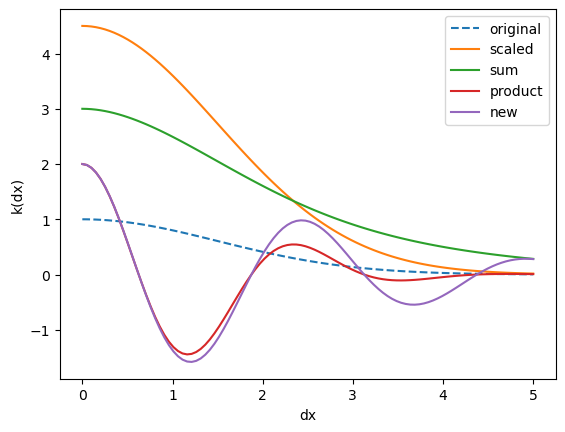

In [39]:
kernel = kernels.ExpSquared(scale=1.5)
plot_kernel(kernel, label="original", ls="dashed")

kernel_scaled = 4.5 * kernels.ExpSquared(scale=1.5)
plot_kernel(kernel_scaled, label="scaled")

kernel_sum = kernels.ExpSquared(scale=1.5) + 2 * kernels.Matern32(scale=2.5)
plot_kernel(kernel_sum, label="sum")

kernel_prod = 2 * kernels.ExpSquared(scale=1.5) * kernels.Cosine(scale=2.5)
plot_kernel(kernel_prod, label="product")

kernel_new =  2 * kernels.Cosine(scale=2.5) * kernels.Matern32(scale=2.5)
plot_kernel(kernel_new, label="new")

_ = plt.legend()

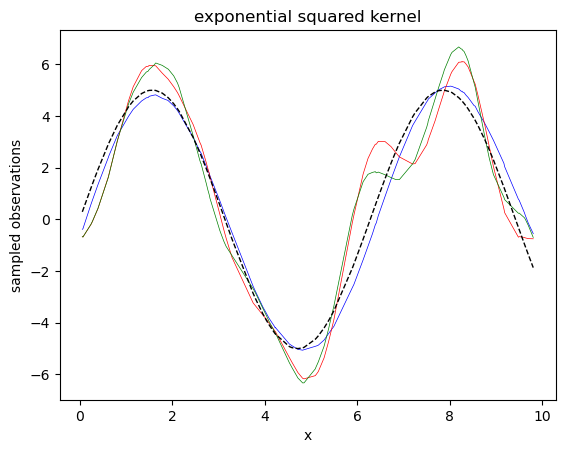

In [43]:
from tinygp import GaussianProcess

def mean_function(x):
    return 5 * jnp.sin(x)

# Let's make up some input coordinates (sorted for plotting purposes)
X = np.sort(np.random.default_rng(1).uniform(0, 10, 100))
gp_exp = GaussianProcess(kernel, X, mean= mean_function)
gp_prod = GaussianProcess(kernel_prod, X, mean= mean_function)
gp_new = GaussianProcess(kernel_new, X, mean= mean_function)

y_exp = gp_exp.sample(random.PRNGKey(6), shape=(1,))
y_prod = gp_prod.sample(random.PRNGKey(6), shape=(1,))
y_new = gp_new.sample(random.PRNGKey(6), shape=(1,))
plt.plot(X, y_exp.T, color = "b", lw=0.5)
plt.plot(X, y_prod.T, color = "r", lw=0.5)
plt.plot(X, y_new.T, color = "g", lw=0.5)
plt.plot(X, mean_function(X), color = "k", lw=1 , ls = "dashed")
plt.xlabel("x")
plt.ylabel("sampled observations")
_ = plt.title("exponential squared kernel")

# Result: The samples are quite different.
# The samples are quite similar if we use a mean function